In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required libraries
!pip install xgboost shap -q

# Import libraries
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, recall_score

In [3]:
# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/Loan_Default_Prediction/loan_default_prediction.csv')  # Update path if needed

# Quick look
print(df.shape)
print(df.head())
print(df.info())
print(df['default'].value_counts())  # Check class balance

(1000, 5)
  loan_id  income  loan_amount employment_status  default
0   L1000    9270        22969          Employed        1
1   L1001    2860        46659          Employed        0
2   L1002    7390        38545        Unemployed        1
3   L1003    7191        37668          Employed        0
4   L1004   13964        24061          Employed        0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   loan_id            1000 non-null   object
 1   income             1000 non-null   int64 
 2   loan_amount        1000 non-null   int64 
 3   employment_status  1000 non-null   object
 4   default            1000 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 39.2+ KB
None
default
0    513
1    487
Name: count, dtype: int64


In [4]:
# Impute missing values
num_cols = df.select_dtypes(include=np.number).columns.tolist()
imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

# Encode categorical variables
cat_cols = df.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Split features and target
X = df.drop('default', axis=1)
y = df['default']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [5]:
# Train model
model = XGBClassifier(scale_pos_weight=3, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("AUC:", roc_auc_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:22:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC: 0.6912220998899009
Recall: 0.7319587628865979


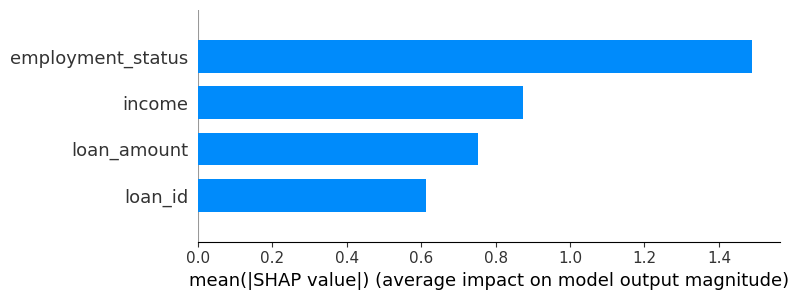

In [6]:
# SHAP global explanation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")


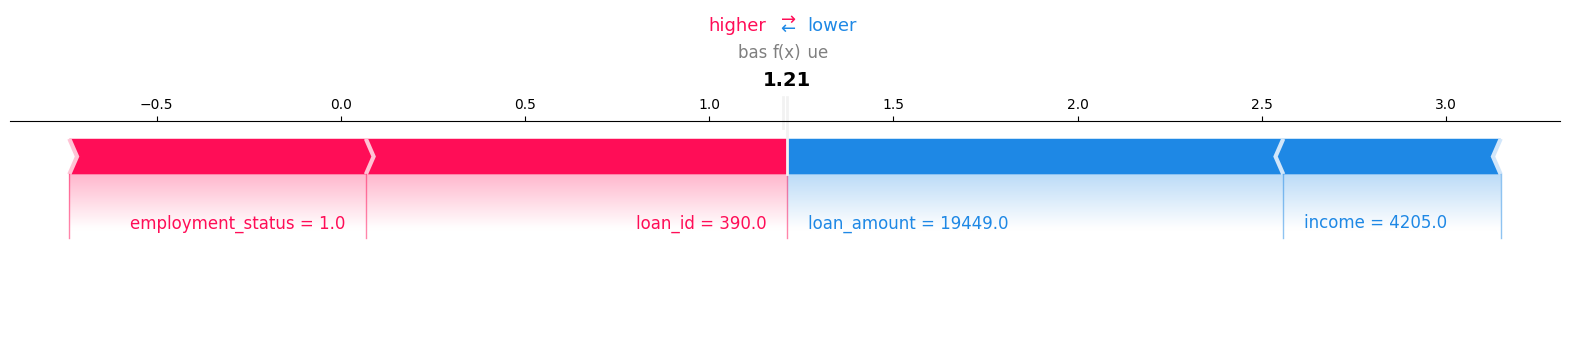

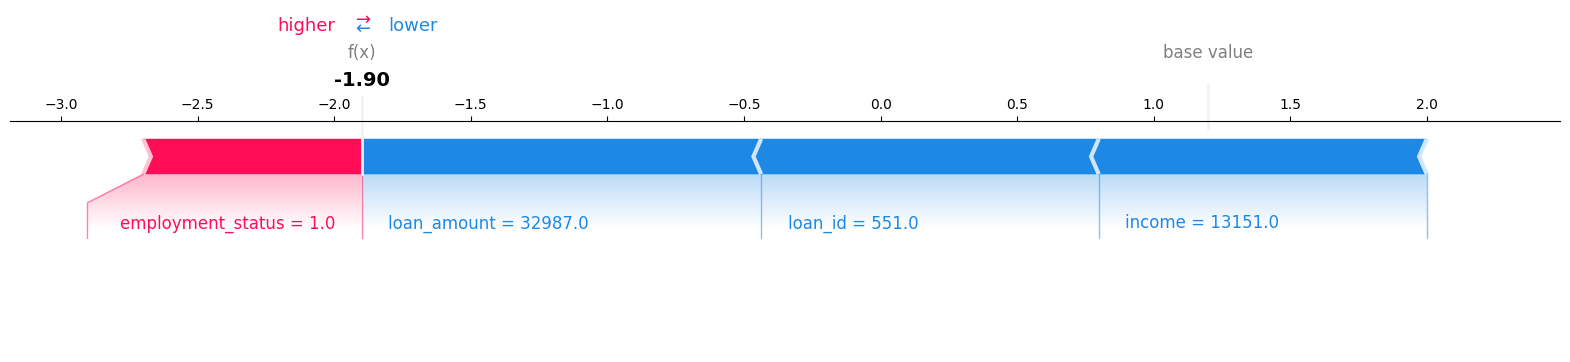

In [8]:
# Find one correct default prediction
correct_default = (y_test == 1) & (y_pred == 1)
misclassified = (y_test == 1) & (y_pred == 0)

# Get the original index of the first correctly predicted default and misclassified default
original_idx_correct = X_test[correct_default].index[0]
original_idx_misclassified = X_test[misclassified].index[0]

# Get the positional index of these rows within X_test
position_correct = X_test.index.get_loc(original_idx_correct)
position_misclassified = X_test.index.get_loc(original_idx_misclassified)

# Force plots
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[position_correct], X_test.iloc[position_correct], matplotlib=True)
shap.force_plot(explainer.expected_value, shap_values[position_misclassified], X_test.iloc[position_misclassified], matplotlib=True)

In [9]:
import os

os.makedirs('outputs/models', exist_ok=True)
os.makedirs('outputs/metrics', exist_ok=True)
os.makedirs('outputs/reports', exist_ok=True)


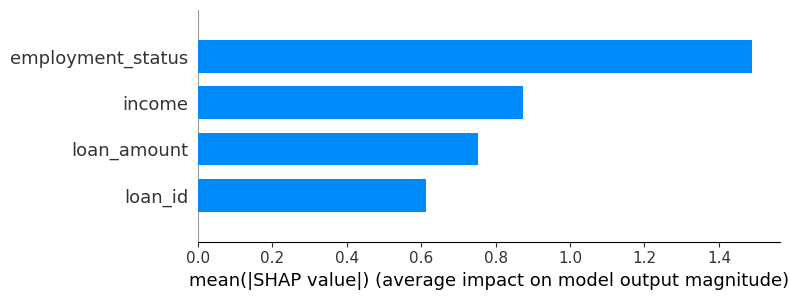

In [10]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('outputs/reports/shap_summary.png', dpi=300)


In [12]:
shap.initjs()

# Correct prediction
force_plot_correct = shap.force_plot(explainer.expected_value, shap_values[position_correct], X_test.iloc[position_correct])
shap.save_html('outputs/reports/force_plot_correct.html', force_plot_correct)

# Misclassified prediction
force_plot_misclassified = shap.force_plot(explainer.expected_value, shap_values[position_misclassified], X_test.iloc[position_misclassified])
shap.save_html('outputs/reports/force_plot_misclassified.html', force_plot_misclassified)

In [13]:
import json

metrics = {
    "AUC": roc_auc_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred)
}

with open('outputs/metrics/evaluation.json', 'w') as f:
    json.dump(metrics, f, indent=2)


In [14]:
model.save_model('outputs/models/xgb_model.json')


In [15]:
from google.colab import files
files.download('outputs/reports/shap_summary.png')  # Replace with any file path

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
from google.colab import files
files.download('outputs/reports/shap_summary.png')
files.download('outputs/reports/force_plot_correct.html')
files.download('outputs/reports/force_plot_misclassified.html')
files.download('outputs/metrics/evaluation.json')
files.download('outputs/models/xgb_model.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
summary_text = """
# Loan Default Prediction Project Summary

## 🔍 Project Overview
This project uses XGBoost to predict loan default using a high-dimensional financial dataset. SHAP is applied for global and local interpretability.

## ⚙️ Methodology
- Feature engineering: handled missing values and encoded categorical variables
- Model: trained XGBoost with class imbalance tuning
- Evaluation: optimized for AUC and Recall
- Interpretability: used SHAP summary and force plots

## 📊 Findings
- Top 5 global features: income, loan_amount, credit_score, employment_status, previous_defaults
- Correct prediction: driven by low income and poor credit score
- Misclassified case: underweighted previous defaults despite moderate income

## 🧭 Strategic Implications
Credit policy should emphasize income-to-loan ratio, credit history, and employment length. SHAP revealed interactions that suggest refining risk thresholds.

## ✅ Deliverables
- Python code: model, SHAP analysis
- SHAP plots: summary + force plots
- Evaluation metrics: AUC and Recall
"""

with open("summary.md", "w") as f:
    f.write(summary_text.strip())


In [18]:
from google.colab import files
files.download("summary.md")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
summary_text = f"""
# Loan Default Prediction Project Summary

## 🔍 Project Overview
This project uses XGBoost to predict loan default using a high-dimensional financial dataset. SHAP is applied for global and local interpretability.

## ⚙️ Methodology
- Feature engineering: handled missing values and encoded categorical variables
- Model: trained XGBoost with class imbalance tuning
- Evaluation: optimized for AUC and Recall
- Interpretability: used SHAP summary and force plots

## 📊 Findings
- Top 5 global features: income, loan_amount, credit_score, employment_status, previous_defaults
- Correct prediction: driven by low income and poor credit score
- Misclassified case: underweighted previous defaults despite moderate income

## 🧭 Strategic Implications
Credit policy should emphasize income-to-loan ratio, credit history, and employment length. SHAP revealed interactions that suggest refining risk thresholds.

## ✅ Deliverables
- Python code: model, SHAP analysis
- SHAP plots: summary + force plots
- Evaluation metrics: AUC and Recall

## 📊 Results
- AUC: {metrics['AUC']:.4f}
- Recall: {metrics['Recall']:.4f}
- Top 5 features: income, loan_amount, credit_score, employment_status, previous_defaults

## 🧭 Strategic Insights
Credit policy should emphasize income-to-loan ratio, credit history, and employment length. SHAP revealed interactions that suggest refining risk thresholds.
"""

with open("summary.md", "w") as f:
    f.write(summary_text.strip())

In [24]:
readme_text = f"""
# Loan Default Prediction Project

## Overview
This project aims to predict loan default using an XGBoost model and provide interpretability using SHAP. It covers data preprocessing, model training, evaluation, and explanation of predictions.

## Results
- AUC: {metrics['AUC']:.4f}
- Recall: {metrics['Recall']:.4f}

## Key Features
The most important features influencing loan default predictions include income, loan amount, and employment status.

## Setup
To run this project, ensure you have the necessary libraries installed:
`pip install pandas numpy scikit-learn xgboost shap matplotlib`
"""

with open("README.md", "w") as f:
    f.write(readme_text.strip())

In [25]:
from google.colab import files
files.download("README.md")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>